In [1]:
import sys
sys.path.append("../src/")
from data import train_and_testloader_from_pc, dataloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb
from hydra import initialize, compose
import pickle

In [2]:
data = np.load("../data/swiss_roll.npy")
data_phate = np.load("../data/swiss_roll_phate.npy")

In [3]:
initialize(config_path="../conf")
cfg = compose(config_name='config')

/tmp/ipykernel_3164075/114847299.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../conf")


In [4]:
if cfg.model.activation == 'relu':
    activation_fn = torch.nn.ReLU()
elif cfg.model.activation == 'leaky_relu':
    activation_fn = torch.nn.LeakyReLU()
elif cfg.model.activation == 'sigmoid':
    activation_fn = torch.nn.Sigmoid()
else:
    raise ValueError('Unknown activation function')
ckpt_path = '../results/model.ckpt'
model = AEDist.load_from_checkpoint(
    ckpt_path,
    dim=data.shape[1],
    emb_dim=data_phate.shape[1],
    log_dist=cfg.model.log_dist,
    w=cfg.model.w,
    lr=cfg.model.lr,
    activation_fn=activation_fn,
)

In [5]:
with open('../results/procrustes.pkl', 'rb') as file:
    procrustes = pickle.load(file)

In [6]:
X_tensor = torch.from_numpy(data).float()
xhat, z = model(X_tensor)
xhat = xhat.cpu().detach().numpy()
z = z.cpu().detach().numpy()

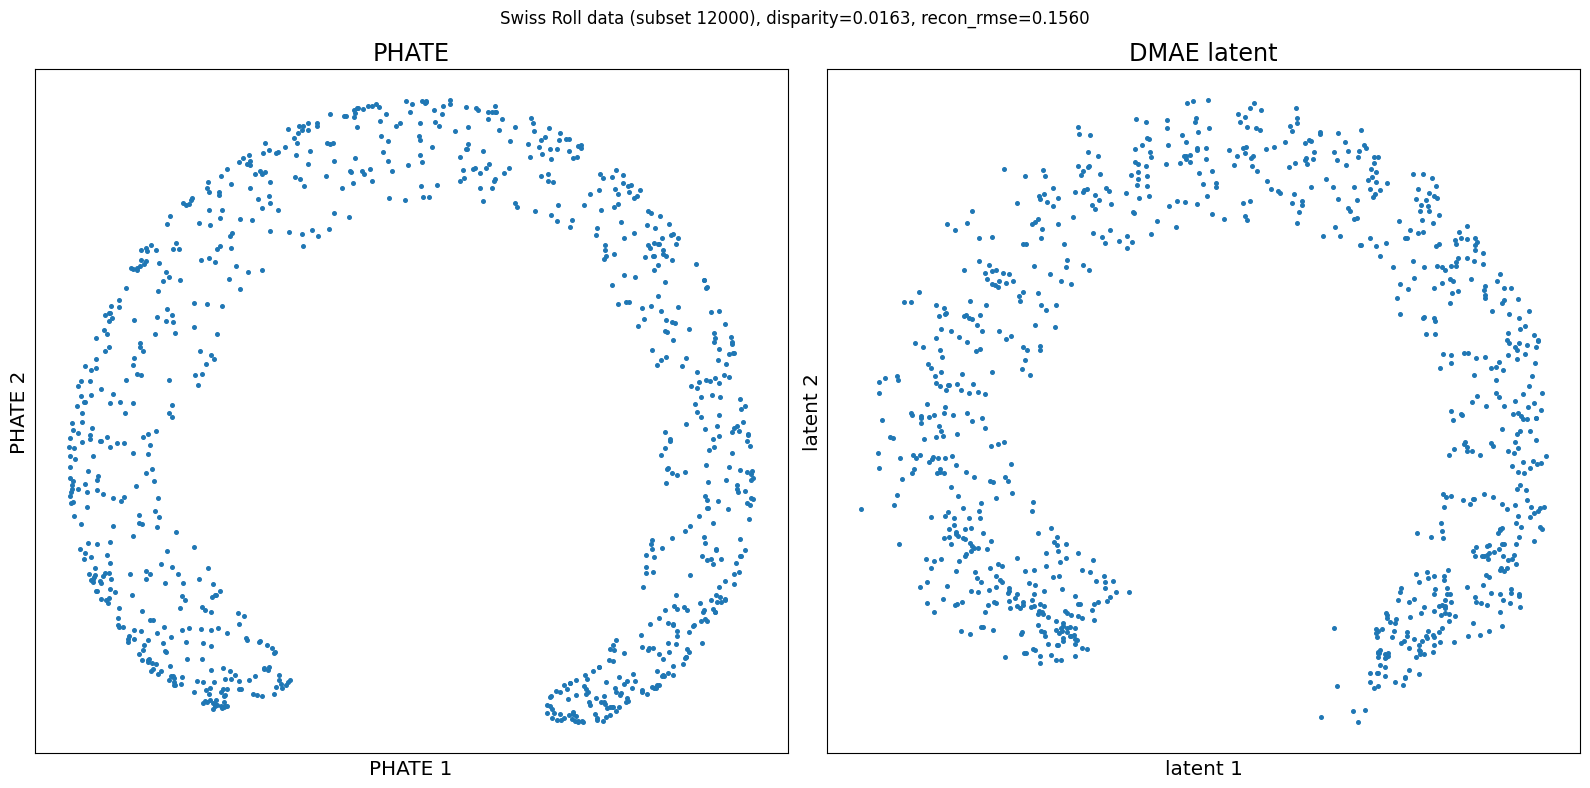

In [7]:
recon_rmse = np.sqrt(np.square(xhat - X_tensor.numpy()).mean())

z_rot = procrustes.transform(z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(data_phate, ax=axes[0],
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, ax=axes[1],
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"Swiss Roll data (subset 12000), disparity={procrustes.disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()